In [30]:
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def generate_missing_values(df, probability):
	missing_df = df.copy()
	num_rows, num_cols = missing_df.shape

	for i in range(num_rows):
		for j in range(num_cols):
			if np.random.random() < probability:
				missing_df.iat[i, j] = np.nan

	return missing_df

def generate_missing_csv(input_file, output_file, probability):
	df = pd.read_csv(input_file)
	missing_df = generate_missing_values(df, probability)
	missing_df.to_csv(output_file, index=False)


def fill_most_frequent(df, column):
	most_frequent_value = df[column].mode().values[0]
	df[column].fillna(most_frequent_value, inplace=True)


def fill_years(df):
	last_year = 1950
	for index, row in df.iterrows():
		if pd.isna(row['Year']):
			df.at[index, 'Year'] = last_year
			last_year += 1
		else:
			last_year = row['Year'] + 1
	
	return df


def to_float(value):
		if value is np.nan:
			return np.nan
		str_value = str(value)
		str_value = str_value.replace(',', '').replace('%', '')
		return float(str_value)


def fill_with_average(df: pd.DataFrame, column, min_value, max_value):
	last_non_empty_population = min_value
	df[column] = df[column].apply(to_float)

	for index, row in df.iterrows():
		if pd.isna(row[column]):
			next_non_empty_index = index + 1
			next_non_empty_population = max_value
			while next_non_empty_index < len(df) and pd.isna(df.at[next_non_empty_index, column]):
				next_non_empty_index += 1
			if next_non_empty_index < len(df):
				next_non_empty_population = df.at[next_non_empty_index, column]
			mean_population = (last_non_empty_population + next_non_empty_population) / 2

			df.at[index, column] = mean_population

			last_non_empty_population = mean_population
		else:
			last_non_empty_population = row[column]

	return df


def process_missing_values(input_file):
	df = pd.read_csv(input_file)

	empty_cells_by_rows = df.isnull().sum(axis=1)
	max_empty_cells_by_rows = empty_cells_by_rows.max()

	empty_cells_by_columns = df.isnull().sum(axis=0)
	print(empty_cells_by_columns)
	max_empty_cells_by_columns = empty_cells_by_columns.max()
	filtered_indexes = empty_cells_by_columns[empty_cells_by_columns == max_empty_cells_by_columns].index.tolist()

	row_threshold = df.shape[1] - max_empty_cells_by_rows + 1
	df = df.dropna(axis=0, thresh=row_threshold)
	df.drop(filtered_indexes, axis=1, inplace=True)
	
	df.info()

	for column in df.columns:
		if column == 'Year':
			df = fill_years(df)
		elif column in ['Population', 'Density (Pop/km2)']:
			if column == 'Population':
				min_value = 2500000000
				max_value = 8100000000
			else:
				min_value = 16
				max_value = 55
			df = fill_with_average(df=df, column=column, min_value=min_value, max_value=max_value)
		elif df[column].dtype == 'float64':
			df[column] = df[column].fillna(df[column].median())
		else:
			fill_most_frequent(df, column)
		if df[column].dtype is str:
			df[column] = df[column].apply(convert_to_ascii)
	print(df)
	df.to_csv('~/6-term/MML/labs/2/processed.csv')
	return df


def convert_to_ascii(val):
		if isinstance(val, str):
			return unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode()
		else:
			return val


def create_histogram_from_dataframes(df1, df2):
	def string_to_float(value):
		if value is np.nan:
			return 0
		return to_float(value)
	
	df1['Population'] = df1['Population'].apply(string_to_float)

	bins = range(1950, 2023, 5)
	df1_median_pop = []
	df2_median_pop = []

	for i in range(len(bins) - 1):
		df1_subset = df1[(df1['Year'] >= bins[i]) & (df1['Year'] < bins[i + 1])]
		df1_median_pop.append(np.median(df1_subset['Population']))
		
		df2_subset = df2[(df2['Year'] >= bins[i]) & (df2['Year'] < bins[i + 1])]
		df2_median_pop.append(np.median(df2_subset['Population']))

	plt.figure(figsize=(10, 6))

	plt.bar(bins[:-1], df1_median_pop, width=5, alpha=0.6, label='DataFrame 1', color='blue')
	plt.bar(bins[:-1], df2_median_pop, width=5, alpha=0.6, label='DataFrame 2', color='orange')

	plt.xlabel('Decade')
	plt.ylabel('Median Population')
	plt.title('Population Distribution by Decade')
	plt.xticks(bins)
	plt.legend()
	plt.show()

In [7]:
input_file = '/home/xojiodujihuk/6-term/MML/labs/2/orig.csv'
output_file = '/home/xojiodujihuk/6-term/MML/labs/2/output.csv'
missing_probability = 0.2

In [22]:
generate_missing_csv(input_file, output_file, missing_probability)

Year                 15
Population           16
Yearly Growth %      15
Number               15
Density (Pop/km2)    20
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 0 to 72
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             56 non-null     float64
 1   Population       57 non-null     object 
 2   Yearly Growth %  56 non-null     object 
 3   Number           56 non-null     object 
dtypes: float64(1), object(3)
memory usage: 2.7+ KB
      Year    Population Yearly Growth %      Number
0   1951.0  2.545135e+09           1.75%  43,808,223
1   1952.0  2.590271e+09           1.85%  47,140,519
2   1953.0  2.640279e+09           1.93%  50,007,898
3   1954.0  2.691979e+09           1.96%  43,808,223
4   1955.0  2.746072e+09           2.01%  54,092,802
5   1956.0  2.801003e+09           2.00%  54,930,490
6   1957.0  2.857867e+09           1.27%  56,864,226
7   1958.0  2.9161

/tmp/ipykernel_1450468/116398987.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(most_frequent_value, inplace=True)


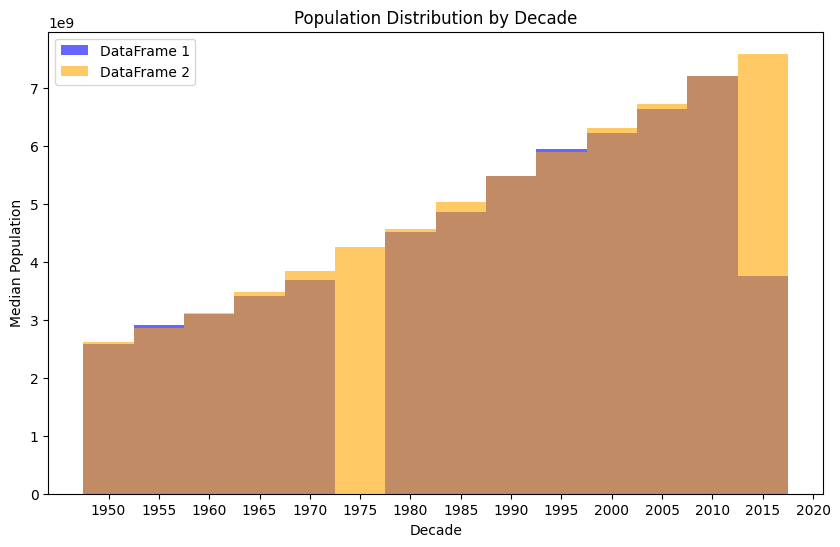

In [31]:
original_csv = pd.read_csv('/home/xojiodujihuk/6-term/MML/labs/2/output.csv')
processed_csv = process_missing_values(input_file=output_file)
create_histogram_from_dataframes(original_csv, processed_csv)